<a href="https://colab.research.google.com/github/Detachm/Bode_plot/blob/main/myosuite-main/docs/source/tutorials/SAR/VAE_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and utilities

In [ ]:
# imports for SAR
!pip install stable-baselines3==1.7.0
!pip install joblib
!pip install scikit-learn
!pip install tqdm
!pip install matplotlib
!pip install gymnasium
!pip install git+https://github.com/facebookresearch/myosuite.git
!pip install stable-baselines3
!pip install numpy
os.chdir('/content/drive/MyDrive/SAR/myosuite-main/docs/source/tutorials/SAR')

  Using cached stable_baselines3-1.7.0-py3-none-any.whl.metadata (4.5 kB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/myosuite.git to /tmp/pip-req-build-3h9nyxay
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/myosuite.git /tmp/pip-req-build-3h9nyxay
  Resolved https://github.com/facebookresearch/myosuite.git to commit 7927eb0153b428812c1db143e0e41144ab57254b
  Running command git submodule update --init --recursive -q
  Pre

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/SAR/myosuite-main/docs/source/tutorials/SAR
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.logger import configure
from stable_baselines3.common.env_util import make_vec_env
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
os.environ['MUJOCO_GL'] = 'glfw'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from SAR_tutorial_utils import *

MyoSuite:> Registering Myo Envs


# VAE core functions

<div style="display: flex; align-items: flex-start;">
    <div style="flex: 1;">
         Next, implement for SAR step by step. The framework follows the basic structure displayed below. Accordingly, we will implement functions that do each of the following:
        <br>
        <br>
        <ol>
            <li>玩耍阶段训练</li>
            <li>捕捉玩耍阶段肌肉激活数据</li>
            <li>使用肌肉激活数据计算SAR</li>
            <li>使用计算后的SAR训练目标数据</li>
        </ol>
        <br>
        As we implement each of the above, we will also go into more detail about best practices for that step.
        <br>
    </div>
</div>

### Step 1: Train a play phase policy

In [ ]:
def train(env_name, policy_name, timesteps, seed):
    # 定义一个训练函数，使用 Stable-Baselines3 的 SAC 算法训练策略。
    # 参数说明：
    # - env_name: 环境名称（字符串）。
    # - policy_name: 策略的唯一标识符（字符串）。
    # - timesteps: 训练的总时间步数（整数）。
    # - seed: 用于区分多个相同参数训练的策略（字符串）。

    env = gym.make(env_name)
    # 创建一个 Gym 环境实例。

    env = Monitor(env)
    # 使用 Monitor 包装环境以记录训练过程中的统计信息。

    env = DummyVecEnv([lambda: env])
    # 使用 DummyVecEnv 将环境包装为向量化环境，以便与 Stable-Baselines3 兼容。

    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    # 使用 VecNormalize 对环境进行归一化处理：
    # - norm_obs=True: 归一化观察值。
    # - norm_reward=False: 不归一化奖励。
    # - clip_obs=10.: 将观察值裁剪到 [-10, 10] 范围。

    net_shape = [400, 300]
    # 定义神经网络的架构，包含两层，分别有 400 和 300 个神经元。

    policy_kwargs = dict(net_arch=dict(pi=net_shape, qf=net_shape))
    # 定义策略网络的参数：
    # - pi: 策略网络的架构。
    # - qf: Q 函数网络的架构。

    model = SAC('MlpPolicy', env, learning_rate=linear_schedule(.001), buffer_size=int(3e5),
            learning_starts=1000, batch_size=256, tau=.02, gamma=.98, train_freq=(1, "episode"),
            gradient_steps=-1,policy_kwargs=policy_kwargs, verbose=1)
    # 创建一个 SAC 模型实例：
    # - 'MlpPolicy': 使用多层感知机策略。
    # - env: 使用的环境。
    # - learning_rate: 学习率，使用线性调度函数。
    # - buffer_size: 经验回放缓冲区大小。
    # - learning_starts: 开始训练前的时间步数。
    # - batch_size: 批量大小。
    # - tau: 目标网络软更新系数。
    # - gamma: 折扣因子。
    # - train_freq: 训练频率（每个 episode 训练一次）。
    # - gradient_steps: 每次更新的梯度步数（-1 表示每次更新与 train_freq 相同）。
    # - policy_kwargs: 策略网络的参数。
    # - verbose: 日志输出级别。

    succ_callback = SaveSuccesses(check_freq=1, env_name=env_name+'_'+seed,
                             log_dir=f'{policy_name}_successes_{env_name}_{seed}')
    # 创建一个回调函数 SaveSuccesses，用于保存训练成功的统计信息：
    # - check_freq: 检查频率（每 1 个时间步检查一次）。
    # - env_name: 保存成功统计信息的环境名称。
    # - log_dir: 保存日志的目录。

    model.set_logger(configure(f'{policy_name}_results_{env_name}_{seed}'))
    # 配置模型的日志记录器，日志将保存到指定目录。

    model.learn(total_timesteps=int(timesteps), callback=succ_callback, log_interval=4)
    # 开始训练模型：
    # - total_timesteps: 总训练时间步数。
    # - callback: 使用 SaveSuccesses 回调函数。
    # - log_interval: 日志记录间隔。

    model.save(f"{policy_name}_model_{env_name}_{seed}")
    # 保存训练好的模型到文件。

    env.save(f'{policy_name}_env_{env_name}_{seed}')
    # 保存归一化环境的状态到文件。

### Step 2: Roll out play phase policy to capture muscle activations over time

In [ ]:
def get_activations(name, env_name, seed, episodes=2000, percentile=80):
    """
    Returns muscle activation data from N runs of a trained policy.

    name: str; policy name (see train())
    env_name: str; name of the gym environment
    seed: str; seed of the trained policy
    episodes: int; optional; how many rollouts?
    percentile: int; optional; percentile to set the reward threshold for considering an episode as successful
    """
    # 定义一个函数，用于从训练好的策略中获取肌肉激活数据。
    # 参数说明：
    # - name: 策略名称（字符串）。
    # - env_name: 环境名称（字符串）。
    # - seed: 训练策略时使用的种子（字符串）。
    # - episodes: 可选参数，表示要运行的回合数（整数，默认为 2000）。
    # - percentile: 可选参数，用于设置奖励阈值的百分位数（整数，默认为 80）。

    with gym.make(env_name) as env:
        env.reset()
        # 创建一个 Gym 环境实例，并在上下文管理器中使用，确保资源释放。
        # 调用 `reset()` 方法初始化环境。

        model = SAC.load(f'{name}_model_{env_name}_{seed}')
        # 加载训练好的 SAC 模型，文件名由策略名称、环境名称和种子组成。

        vec = VecNormalize.load(f'{name}_env_{env_name}_{seed}', DummyVecEnv([lambda: env]))
        # 加载归一化环境的状态，并将其包装为 DummyVecEnv 以与模型兼容。

        # Calculate the reward threshold from 100 preview episodes
        preview_rewards = []
        # 初始化一个列表，用于存储预览回合的奖励。

        for _ in range(100):
            env.reset()
            # 重置环境。

            rewards = 0
            # 初始化奖励计数器。

            done = False
            # 初始化回合结束标志。

            while not done:
                o = env.get_obs()
                # 获取当前观察值。

                o = vec.normalize_obs(o)
                # 对观察值进行归一化处理。

                a, __ = model.predict(o, deterministic=False)
                # 使用模型预测动作，`deterministic=False` 表示使用随机策略。

                next_o, r, done, *_, info = env.step(a)
                # 执行动作，获取下一步的观察值、奖励、回合结束标志和其他信息。

                rewards += r
                # 累加奖励。

            preview_rewards.append(rewards)
            # 将当前回合的总奖励添加到预览奖励列表中。

        reward_threshold = np.percentile(preview_rewards, percentile)
        # 根据预览奖励列表计算奖励阈值，使用指定的百分位数。

        # Run the main episode loop
        solved_acts = []
        # 初始化一个列表，用于存储成功回合的激活数据。

        for _ in tqdm(range(episodes)):
            env.reset()
            # 重置环境。

            rewards, acts = 0, []
            # 初始化奖励计数器和动作列表。

            done = False
            # 初始化回合结束标志。

            while not done:
                o = env.get_obs()
                # 获取当前观察值。

                o = vec.normalize_obs(o)
                # 对观察值进行归一化处理。

                a, __ = model.predict(o, deterministic=False)
                # 使用模型预测动作，`deterministic=False` 表示使用随机策略。

                next_o, r, done, *_, info = env.step(a)
                # 执行动作，获取下一步的观察值、奖励、回合结束标志和其他信息。

                acts.append(env.sim.data.act.copy())
                # 将当前的肌肉激活数据复制并添加到动作列表中。

                rewards += r
                # 累加奖励。

            if rewards > reward_threshold:
                solved_acts.extend(acts)
                # 如果当前回合的总奖励超过奖励阈值，将动作列表添加到成功回合的激活数据中。

    return np.array(solved_acts)
    # 将成功回合的激活数据转换为 NumPy 数组并返回。

### Step 3: Compute SAR from the activation dataset

We use linear representations (i.e., PCA, ICA, normalization) to approximate SAR. These representations are based directly on the motor neuroscience literature of representing muscle synergies (c.f., [Tresch et al, 2006](https://journals.physiology.org/doi/epdf/10.1152/jn.00222.2005)). Such representations also have the advantages of being highly interpretable and efficient for use as control signals. We also found in practice that nonlinear representations (such as VAE decoder networks) did not lead to strong performance are were far less efficient for training.

Before computing SAR, we first seek to understand how informative each individual muscle synergy is for explaining the initial muscle activation dataset. `find_synergies` returns a dictionary (and optionally, a plot) that shows variance accounted for (VAF) by N synergies from the original muscle activation data. In general, we find that using a number of synergies where VAF > 80% leads to good performance, though this value should be treated as a hyperparameter.

In [ ]:
# 定义 Variational Autoencoder (VAE) 模型类
class VAE(nn.Module):
    def __init__(self, input_dim=80, latent_dim=10):
        super(VAE, self).__init__()
        # 编码器：线性层降维 80 ->256-> 128 -> 64 -> 32 -> latent_dim（输出均值和log方差）
        self.fc1 = nn.Linear(input_dim, 256)
        #self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc4_mean = nn.Linear(32, latent_dim)    # 均值输出层
        self.fc4_logvar = nn.Linear(32, latent_dim)  # log方差输出层
        # 解码器：线性层升维 latent_dim -> 32 -> 64 -> 128 -> 80（对称结构）
        self.fc_decode1 = nn.Linear(latent_dim, 32)
        self.fc_decode2 = nn.Linear(32, 64)
        self.fc_decode3 = nn.Linear(64, 128)
        self.fc_decode4 = nn.Linear(128, 256)
        #self.fc_decode5 = nn.Linear(256, 512)
        self.fc_decode6 = nn.Linear(256, input_dim)

    def encode(self, x):
        # 编码器前向传播：生成潜在空间的均值和对数方差
        h = F.relu(self.fc1(x))
        #h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        h = F.relu(self.fc5(h))
        mu = self.fc4_mean(h)       # 潜在均值
        logvar = self.fc4_logvar(h) # 潜在对数方差
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # 重新参数化：从 N(μ, σ^2) 中采样隐变量 z
        std = torch.exp(0.5 * logvar)     # 计算标准差 σ
        eps = torch.randn_like(std)       # 随机噪声 ε ~ N(0, I)
        z = mu + eps * std                # 隐变量 z = μ + σ * ε
        return z

    def decode(self, z):
        # 解码器前向传播：从隐变量重构回原始维度
        h = F.relu(self.fc_decode1(z))
        h = F.relu(self.fc_decode2(h))
        h = F.relu(self.fc_decode3(h))
        h = F.relu(self.fc_decode4(h))
        #h = F.relu(self.fc_decode5(h))
        x_recon = self.fc_decode6(h)      # 输出层（线性层，输出重构结果）
        # 注意：由于输入数据已归一化到 [-1, 1]，这里不使用额外激活函数约束输出
        return x_recon

    def forward(self, x):
        # 完整前向过程：编码 -> 采样 -> 解码
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [ ]:
# 定义函数：训练VAE并计算不同潜在维度下的方差解释率 VAF
def find_synergies_vae(acts, latent_dims_list, epochs=100, lr=0.001, batch_size=32, plot=True, device='cpu'):
    # 2. 将输入数据转换为 numpy 数组并进行 MinMax(-1,1) 归一化
    acts = np.array(acts, dtype=np.float32)              # 转换为 numpy 数组
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_norm = scaler.fit_transform(acts)                  # 对每列特征缩放到 [-1, 1]
    # 转换为 PyTorch 张量并移动到指定设备
    X_tensor = torch.from_numpy(X_norm).float()
    if device == 'cuda' and not torch.cuda.is_available():
        print("警告: CUDA 不可用，自动切换到 CPU。")
        device = 'cpu'
    X_tensor = X_tensor.to(device)

    # 使用 DataLoader 将数据按批划分
    dataset = TensorDataset(X_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    vaf_results = {}  # 字典：存储每个潜在维度对应的 VAF

    # 遍历每个潜在维度，分别训练 VAE 并计算重构的方差解释率
    for latent_dim in latent_dims_list:
        print(f"训练 VAE，潜在维度 = {latent_dim} ...")
        # 3. 初始化VAE模型和优化器
        model = VAE(input_dim=X_tensor.shape[1], latent_dim=latent_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # 训练循环
        for epoch in range(epochs):
            model.train()
            total_loss = 0.0
            for batch_data, in data_loader:
                batch_data = batch_data.to(device)
                # 前向传播计算重构结果、潜在均值和log方差
                recon_batch, mu, logvar = model(batch_data)
                # 1. 计算重构损失 (MSE)
                recon_loss = F.mse_loss(recon_batch, batch_data, reduction='sum') / batch_data.size(0)
                # 计算 KL 散度损失（基于解析表达式）
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_data.size(0)
                # 4. KL warm-up：前50轮线性增加 KL 损失权重
                kl_weight = (epoch + 1) / 2000.0 if epoch < 200 else 0.1
                #kl_weight = 0
                # 总损失 = 重构损失 + KL损失 * 权重
                loss = recon_loss + kl_weight * kl_loss
                # 反向传播和参数更新
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * batch_data.size(0)
            # 打印每轮训练的平均损失（每隔10轮或最后一轮输出一次）
            avg_loss = total_loss / len(dataset)
            if (epoch + 1) % 10 == 0 or epoch == 0 or (epoch + 1) == epochs:
                print(f"  Epoch {epoch+1}/{epochs} - 平均损失: {avg_loss:.4f} "
                      f"(重构: {recon_loss.item():.4f}, KL: {kl_loss.item():.4f}, 权重: {kl_weight:.2f})")

        # 训练结束，利用训练好的模型重构整个数据集以计算 VAF
        model.eval()
        with torch.no_grad():
            # 用编码器获取每个样本的潜在均值作为隐变量（避免随机采样导致不稳定）
            mu, logvar = model.encode(X_tensor)
            z = mu  # 使用均值 mu 代表潜在变量
            X_recon_full = model.decode(z)
        # 将原始数据和重构数据转回 CPU 的 numpy（均为归一化后的数据）
        X_orig = X_tensor.detach().cpu().numpy()
        X_recon = X_recon_full.detach().cpu().numpy()
        # 计算重构误差平方和 (SSE) 和原始数据总平方和 (SST)
        SSE = np.sum((X_orig - X_recon) ** 2)                         # 重构误差的平方和
        SST = np.sum((X_orig - np.mean(X_orig, axis=0)) ** 2)         # 原始数据绕均值的平方和
        # 计算方差解释率 VAF = 1 - SSE/SST
        vaf = 1 - SSE / SST
        vaf_results[latent_dim] = vaf
        print(f"潜在维度 {latent_dim} 的 VAF = {vaf:.4f}")

        # 释放 GPU 显存（如使用GPU，加速垃圾回收）
        del model
        if device == 'cuda':
            torch.cuda.empty_cache()

    # 如果需要绘制 VAF 随潜在维度变化曲线
    if plot:
        dims = list(vaf_results.keys())
        vafs = [vaf_results[d] for d in dims]
        plt.figure(figsize=(6,4))
        plt.plot(dims, vafs, marker='o')
        plt.xlabel("Number of potential dimensions")
        plt.ylabel("VAF")
        plt.grid(True)
        plt.show()

    # 返回字典：latent_dim -> VAF
    return vaf_results

In [ ]:
def compute_VAE_SAR(acts, latent_dim, epochs=100, lr=0.001, batch_size=32, device='cuda'):
    acts = np.array(acts, dtype=np.float32)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_norm = scaler.fit_transform(acts)
    X_tensor = torch.from_numpy(X_norm).float().to(device)

    if device == 'cuda' and not torch.cuda.is_available():
        print("警告: CUDA 不可用，自动切换到 CPU。")
        device = 'cpu'

    dataset = TensorDataset(X_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = VAE(input_dim=X_tensor.shape[1], latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch_data, in data_loader:
            batch_data = batch_data.to(device)
            recon_batch, mu, logvar = model(batch_data)

            recon_loss = F.mse_loss(recon_batch, batch_data, reduction='sum') / batch_data.size(0)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_data.size(0)
            kl_weight = (epoch + 1) / 1000.0 if epoch < 100 else 0.1
            loss = recon_loss + kl_weight * kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_data.size(0)
            # 打印每轮训练的平均损失（每隔10轮或最后一轮输出一次）
        avg_loss = total_loss / len(dataset)
        if (epoch + 1) % 10 == 0 or epoch == 0 or (epoch + 1) == epochs:
            print(f"  Epoch {epoch+1}/{epochs} - 平均损失: {avg_loss:.4f} "
                  f"(重构: {recon_loss.item():.4f}, KL: {kl_loss.item():.4f}, 权重: {kl_weight:.2f})")

    return model, scaler


### Step 4: Use computed SAR to train on target task

In order to train with SAR, we initialize a `SynNoSynWrapper`, which implements the policy architecture presented below.

The policy takes as input $o_t$ and outputs an $O+N$-dimensional action vector, $a_{t}^{O+N}$, where $O$ is the dimensionality of the original action manifold and $N$ is the dimensionality of the synergistic manifold. The first $N$ synergistic actions are passed through $SAR(a_{t}^{N})=a_{t}^{SAR}$ to recover the synergistic muscle activations. The subsequent $O$ task-specific activations are mixed with the task-general activations using a linear blend $\varphi$ to recover the final action $a_t^*$ that steps the environment forward. Note that for the locomotion experiments presented next, it was actually found that purely relying on the synergistic, task-general pathway ($\varphi=1$) was sufficient for learning robust locomotion (see end-to-end example later in the notebook).

<div style="width:100%;">
    <img src="./SAR_images/pol_arch.png" alt="Policy Architecture" style="width:850px; display:block; margin-left:auto; margin-right:auto;"/>
</div>

In [ ]:
class VAESynNoSynWrapper(gym.ActionWrapper):
    def __init__(self, env, vae, normalizer, phi):
        super().__init__(env)

        self.vae = vae.eval()
        self.normalizer = normalizer
        self.weight = phi

        self.device = next(self.vae.parameters()).device

        with torch.no_grad():
            dummy_input = torch.zeros(1, env.action_space.shape[0]).to(self.device)
            z_mean, _ = self.vae.encode(dummy_input)
            self.syn_act_space = z_mean.shape[1]

        self.no_syn_act_space = env.action_space.shape[0]
        self.full_act_space = self.syn_act_space + self.no_syn_act_space

        self.action_space = gym.spaces.Box(
            low=-1., high=1., shape=(self.full_act_space,), dtype=np.float32
        )

    def action(self, act):
        syn_action = act[:self.syn_act_space]
        no_syn_action = act[self.syn_act_space:]

        #latent = self.normalizer.inverse_transform([syn_action])
        latent_tensor = torch.tensor([syn_action], dtype=torch.float32).to(self.device)

        with torch.no_grad():
            decoded_action = self.vae.decode(latent_tensor).cpu().numpy()[0]

        final_action = self.weight * decoded_action + (1 - self.weight) * no_syn_action
        return final_action


Additionally, we initialize a `SynergyWrapper`, which implements a variation of the above policy architecture that only leverages task-general synergistic activations (i.e., a more efficient implementation for handling the case where $\varphi=1$).

In [ ]:
class VAESynergyWrapper(gym.ActionWrapper):
    """
    使用 PyTorch VAE 模型将动作空间映射到潜在空间，并将其解码回原始肌肉激活空间。
    """

    def __init__(self, env, encoder, decoder, normalizer):
        super().__init__(env)

        self.encoder = encoder.eval()
        self.decoder = decoder.eval()
        self.normalizer = normalizer

        # 获取 PyTorch 模型的 device
        self.device = next(encoder.parameters()).device

        # 使用 dummy input 获取 latent 维度
        with torch.no_grad():
            dummy_input = torch.zeros(1, env.observation_space.shape[0]).to(self.device)
            z_mean, _ = self.encoder(dummy_input)
            self.latent_dim = z_mean.shape[1]

        # 定义新的动作空间（潜在空间）
        self.action_space = gym.spaces.Box(
            low=-1., high=1., shape=(self.latent_dim,), dtype=np.float32
        )

    def action(self, act):
        # act: numpy array of shape (latent_dim,)

        # 将归一化潜在变量逆变换回标准潜在空间
        latent_np = self.normalizer.inverse_transform([act])
        latent_tensor = torch.tensor(latent_np, dtype=torch.float32).to(self.device)

        # 用 decoder 解码回肌肉激活空间
        with torch.no_grad():
            decoded = self.decoder(latent_tensor).cpu().numpy()[0]

        return decoded


We proceed to train a policy with this architecture using `SAR_RL`. We find that a blend weight $\varphi$=0.66 between the synergistic (task-general) and nonsynergistic (task-specific) activations works best in practice, though this should also be considered a hyperparameter that may require optimization for specific use cases.

In [ ]:
def VAE_RL(env_name, policy_name, timesteps, seed, vae, normalizer, phi=.66, syn_nosyn=True):
    if syn_nosyn:
        env = VAESynNoSynWrapper(gym.make(env_name), vae, normalizer, phi)
    else:
        env = gym.make(env_name)

    env = Monitor(env)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)

    net_shape = [400, 300]
    policy_kwargs = dict(net_arch=dict(pi=net_shape, qf=net_shape))

    '''model = SAC('MlpPolicy', env, learning_rate=3e-4, buffer_size=int(3e5),
                learning_starts=5000, batch_size=256, tau=.02, gamma=.98,
                train_freq=(1, "episode"), gradient_steps=-1,
                policy_kwargs=policy_kwargs, verbose=1)'''

    model = SAC('MlpPolicy', env, learning_rate=linear_schedule(.001), buffer_size=int(3e5),
            learning_starts=5000, batch_size=256, tau=.02, gamma=.98, train_freq=(1, "episode"),
            gradient_steps=-1,policy_kwargs=policy_kwargs, verbose=1)


    model.set_logger(configure(f'{policy_name}_results_{env_name}_{seed}'))
    model.learn(total_timesteps=int(timesteps), log_interval=4)
    model.save(f"{policy_name}_model_{env_name}_{seed}")
    env.save(f'{policy_name}_env_{env_name}_{seed}')


# SAR 部分


In [ ]:
def find_synergies(acts, plot=True):
    """
    Computed % variance explained in the original muscle activation data with N synergies.

    acts: np.array; rollout data containing the muscle activations
    plot: bool; whether to plot the result
    """
    # 定义一个函数，用于计算原始肌肉激活数据中由 N 个协同作用解释的方差百分比。
    # 参数说明：
    # - acts: 包含肌肉激活数据的 NumPy 数组。
    # - plot: 是否绘制结果图表（布尔值，默认为 True）。

    syn_dict = {}
    # 初始化一个空字典，用于存储每个协同作用数量对应的方差解释比例。

    for i in range(acts.shape[1]):
        # 遍历肌肉激活数据的每个维度（即每个协同作用的数量）。

        pca = PCA(n_components=i+1)
        # 创建一个 PCA（主成分分析）实例，设置主成分数量为 i+1。

        _ = pca.fit_transform(acts)
        # 对输入的肌肉激活数据进行 PCA 转换（降维）。

        syn_dict[i+1] =  round(sum(pca.explained_variance_ratio_), 4)
        # 计算当前协同作用数量解释的总方差比例，并保留 4 位小数。
        # 将结果存储到字典中，键为协同作用数量，值为方差解释比例。

    if plot:
        # 如果 `plot` 参数为 True，则绘制结果图表。

        plt.plot(list(syn_dict.keys()), list(syn_dict.values()))
        # 绘制协同作用数量与方差解释比例的关系曲线。

        plt.title('VAF by N synergies')
        # 设置图表标题。

        plt.xlabel('# synergies')
        # 设置 x 轴标签为协同作用数量。

        plt.ylabel('VAF')
        # 设置 y 轴标签为方差解释比例（VAF）。

        plt.grid()
        # 添加网格线以便于观察。

        plt.show()
        # 显示图表。

    return syn_dict
    # 返回包含协同作用数量与方差解释比例的字典。

In [ ]:
def SAR_RL(env_name, policy_name, timesteps, seed, ica, pca, normalizer, phi=.66, syn_nosyn=True):
    """
    Trains a policy using sb3 implementation of SAC + SynNoSynWrapper.

    env_name: str; name of gym env.
    policy_name: str; choose unique identifier of this policy
    timesteps: int; how long you want to train your policy for
    seed: str (not int); relevant if you want to train multiple policies with the same params
    ica: the ICA object
    pca: the PCA object
    normalizer: the normalizer object
    phi: float; blend parameter between synergistic and nonsynergistic activations
    """
    # 定义一个函数，用于使用 Stable-Baselines3 的 SAC 算法和 SynNoSynWrapper 包装器训练策略。
    # 参数说明：
    # - env_name: 环境名称（字符串）。
    # - policy_name: 策略的唯一标识符（字符串）。
    # - timesteps: 训练的总时间步数（整数）。
    # - seed: 用于区分多个相同参数训练的策略（字符串）。
    # - ica: ICA 模型对象。
    # - pca: PCA 模型对象。
    # - normalizer: 归一化器对象。
    # - phi: 协同作用和非协同作用动作的混合权重参数（浮点数，默认为 0.66）。
    # - syn_nosyn: 是否使用 SynNoSynWrapper 包装器（布尔值，默认为 True）。

    if syn_nosyn:
        env = SynNoSynWrapper(gym.make(env_name), ica, pca, normalizer, phi)
        # 如果 `syn_nosyn` 为 True，则使用 SynNoSynWrapper 包装环境。
    else:
        env = SynergyWrapper(gym.make(env_name), ica, pca, normalizer)
        # 如果 `syn_nosyn` 为 False，则使用 SynergyWrapper 包装环境。

    env = Monitor(env)
    # 使用 Monitor 包装环境以记录训练过程中的统计信息。

    env = DummyVecEnv([lambda: env])
    # 使用 DummyVecEnv 将环境包装为向量化环境，以便与 Stable-Baselines3 兼容。

    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    # 使用 VecNormalize 对环境进行归一化处理：
    # - norm_obs=True: 归一化观察值。
    # - norm_reward=False: 不归一化奖励。
    # - clip_obs=10.: 将观察值裁剪到 [-10, 10] 范围。

    net_shape = [400, 300]
    # 定义神经网络的架构，包含两层，分别有 400 和 300 个神经元。

    policy_kwargs = dict(net_arch=dict(pi=net_shape, qf=net_shape))
    # 定义策略网络的参数：
    # - pi: 策略网络的架构。
    # - qf: Q 函数网络的架构。

    model = SAC('MlpPolicy', env, learning_rate=linear_schedule(.001), buffer_size=int(3e5),
            learning_starts=5000, batch_size=256, tau=.02, gamma=.98, train_freq=(1, "episode"),
            gradient_steps=-1,policy_kwargs=policy_kwargs, verbose=1)
    # 创建一个 SAC 模型实例：
    # - 'MlpPolicy': 使用多层感知机策略。
    # - env: 使用的环境。
    # - learning_rate: 学习率，使用线性调度函数。
    # - buffer_size: 经验回放缓冲区大小。
    # - learning_starts: 开始训练前的时间步数。
    # - batch_size: 批量大小。
    # - tau: 目标网络软更新系数。
    # - gamma: 折扣因子。
    # - train_freq: 训练频率（每个 episode 训练一次）。
    # - gradient_steps: 每次更新的梯度步数（-1 表示每次更新与 train_freq 相同）。
    # - policy_kwargs: 策略网络的参数。
    # - verbose: 日志输出级别。

    succ_callback = SaveSuccesses(check_freq=1, env_name=env_name+'_'+seed,
                             log_dir=f'{policy_name}_successes_{env_name}_{seed}')
    # 创建一个回调函数 SaveSuccesses，用于保存训练成功的统计信息：
    # - check_freq: 检查频率（每 1 个时间步检查一次）。
    # - env_name: 保存成功统计信息的环境名称。
    # - log_dir: 保存日志的目录。

    model.set_logger(configure(f'{policy_name}_results_{env_name}_{seed}'))
    # 配置模型的日志记录器，日志将保存到指定目录。

    model.learn(total_timesteps=int(timesteps), callback=succ_callback, log_interval=4)
    # 开始训练模型：
    # - total_timesteps: 总训练时间步数。
    # - callback: 使用 SaveSuccesses 回调函数。
    # - log_interval: 日志记录间隔。

    model.save(f"{policy_name}_model_{env_name}_{seed}")
    # 保存训练好的模型到文件。

    env.save(f'{policy_name}_env_{env_name}_{seed}')
    # 保存归一化环境的状态到文件。

In [ ]:
class SynNoSynWrapper(gym.ActionWrapper):
    """
    gym.ActionWrapper that reformulates the action space as the combination of a task-general synergy space and a
    task-specific original space, and uses this mix to step the environment in the original action space.
    """
    # 定义一个自定义的 Gym 动作包装器类 `SynNoSynWrapper`。
    # 该包装器将动作空间重新定义为任务通用的协同作用空间和任务特定的原始空间的组合，
    # 并使用这种混合动作来在原始动作空间中执行环境的步进操作。

    def __init__(self, env, ica, pca, scaler, phi):
        super().__init__(env)
        # 初始化父类 `gym.ActionWrapper`，并传入环境实例 `env`。

        self.ica = ica
        # 保存独立成分分析 (ICA) 模型。

        self.pca = pca
        # 保存主成分分析 (PCA) 模型。

        self.scaler = scaler
        # 保存归一化器 (Scaler) 对象。

        self.weight = phi
        # 保存协同作用和非协同作用动作的混合权重参数 `phi`。

        self.syn_act_space = self.pca.components_.shape[0]
        # 协同作用动作空间的维度，等于 PCA 模型的主成分数量。

        self.no_syn_act_space = env.action_space.shape[0]
        # 非协同作用动作空间的维度，等于环境原始动作空间的维度。

        self.full_act_space = self.syn_act_space + self.no_syn_act_space
        # 总动作空间的维度，为协同作用动作空间和非协同作用动作空间的维度之和。

        self.action_space = gym.spaces.Box(low=-1., high=1., shape=(self.full_act_space,), dtype=np.float32)
        # 定义新的动作空间为一个连续的 Box 空间，其范围为 [-1, 1]，维度为总动作空间的维度。

    def action(self, act):
        # 重写 `action` 方法，用于将输入的动作转换为原始动作空间中的动作。

        syn_action = act[:self.syn_act_space]
        # 从输入动作中提取协同作用部分（前 `syn_act_space` 个维度）。

        no_syn_action = act[self.syn_act_space:]
        # 从输入动作中提取非协同作用部分（后 `no_syn_act_space` 个维度）。

        syn_action = self.pca.inverse_transform(
            self.ica.inverse_transform(
                self.scaler.inverse_transform([syn_action])
            )
        )[0]
        # 对协同作用动作依次进行逆归一化、ICA 逆变换和 PCA 逆变换，
        # 将其还原为原始动作空间中的动作。

        final_action = self.weight * syn_action + (1 - self.weight) * no_syn_action
        # 根据权重参数 `phi`，将协同作用动作和非协同作用动作混合，生成最终的动作。

        return final_action
        # 返回最终的动作，用于在环境中执行。

In [ ]:
def compute_SAR(acts, n_syn, save=False):
    """
    Takes activation data and desired n_comp as input and returns/optionally saves the ICA, PCA, and Scaler objects

    acts: np.array; rollout data containing the muscle activations
    n_comp: int; number of synergies to use
    save: bool; whether to save the resulting models to disk
    """
    # 定义一个函数，用于计算肌肉激活数据的协同作用，并返回或保存 ICA、PCA 和归一化对象。
    # 参数说明：
    # - acts: 包含肌肉激活数据的 NumPy 数组。
    # - n_syn: 使用的协同作用数量（整数）。
    # - save: 是否保存结果模型到磁盘（布尔值，默认为 False）。

    pca = PCA(n_components=n_syn)
    # 创建一个 PCA（主成分分析）实例，设置主成分数量为 n_syn。

    pca_act = pca.fit_transform(acts)
    # 对输入的肌肉激活数据进行 PCA 转换（降维），并返回降维后的数据。

    ica = FastICA()
    # 创建一个 FastICA（快速独立成分分析）实例。

    pcaica_act = ica.fit_transform(pca_act)
    # 对 PCA 降维后的数据进行 ICA 转换，提取独立成分。

    normalizer = MinMaxScaler((-1, 1))
    # 创建一个 MinMaxScaler 实例，用于将数据归一化到 [-1, 1] 范围。

    normalizer.fit(pcaica_act)
    # 使用 ICA 转换后的数据拟合归一化器。

    if save:
        # 如果 `save` 参数为 True，则将模型保存到磁盘。

        joblib.dump(ica, 'ica_demo.pkl')
        # 将 ICA 模型保存到文件 `ica_demo.pkl`。

        joblib.dump(pca, 'pca_demo.pkl')
        # 将 PCA 模型保存到文件 `pca_demo.pkl`。

        joblib.dump(normalizer, 'scaler_demo.pkl')
        # 将归一化器保存到文件 `scaler_demo.pkl`。

    return ica, pca, normalizer
    # 返回 ICA、PCA 和归一化器对象。

# Full training example 1: SAR x physiological locomotion

Now that we have defined the core functions for implementing SAR, we will now train a locomotion policy using MyoLegs. In this example:
- a policy is trained on straight flat walking task for 1.5M steps (`myoLegWalk-v0`)
- after training, we collect muscle activation data from policy rollouts
- Variance accounted for (VAF) by N synergies is computed. Here, we use 20 synergies from the 80-dimensional leg muscle activations
- SAR is used to train on:
    - a hilly terrain walking task (`myoLegHillyTerrainWalk-v0`)
    - an uneven terrain walking task (`myoLegRoughTerrainWalk-v0`)
    - a stair climbing task (`myoLegStairTerrainWalk-v0`)

<strong>Note: we also provide the option of using pretrained policies/representations at some of the above steps. Run the code below depending on your preferences.</strong>

# Step 1.1

First, we acquire our synergistic action representation. We provide two options for this:

<strong>Option A: Get SAR from scratch (i.e., train on `myoLegWalk-v0` as play period → get muscle activations → compute SAR).</strong>

<strong>Option B: Use the precomputed SAR.</strong>

## Option 1.1.A: Get SAR from scratch

In [ ]:
train('myoLegWalk-v0', 'play_period', 1.5e6, '0')

    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


/usr/local/lib/python3.11/dist-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


Streaming output truncated to the last 5000 lines.
|    n_updates       | 888759   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 248      |
|    ep_rew_mean     | 2.17e+03 |
| time/              |          |
|    episodes        | 5932     |
|    fps             | 64       |
|    time_elapsed    | 13741    |
|    total_timesteps | 891156   |
| train/             |          |
|    actor_loss      | -501     |
|    critic_loss     | 69.7     |
|    ent_coef        | 0.0466   |
|    ent_coef_loss   | 0.0107   |
|    learning_rate   | 0.000406 |
|    n_updates       | 889844   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 252      |
|    ep_rew_mean     | 2.21e+03 |
| time/              |          |
|    episodes        | 5936     |
|    fps             | 64       |
|    time_elapsed    | 13759    |
|    total_timesteps | 892284  

Simulation couldn't be stepped as intended. Issuing a reset
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 287      |
|    ep_rew_mean     | 2.51e+03 |
| time/              |          |
|    episodes        | 7108     |
|    fps             | 64       |
|    time_elapsed    | 18645    |
|    total_timesteps | 1209957  |
| train/             |          |
|    actor_loss      | -506     |
|    critic_loss     | 95.7     |
|    ent_coef        | 0.0488   |
|    ent_coef_loss   | -1.33    |
|    learning_rate   | 0.000194 |
|    n_updates       | 1208666  |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 278      |
|    ep_rew_mean     | 2.44e+03 |
| time/              |          |
|    episodes        | 7112     |
|    fps             | 64       |
|    time_elapsed    | 18661    |
|    total_timesteps | 1211025  |
| train/             |          |
|    actor_loss      |

In [ ]:
# 设置虚拟显示
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# 设置环境变量
import os
os.environ["DISPLAY"] = ":0"
os.environ["MUJOCO_GL"] = "osmesa"  # 使用 EGL 渲染

In [ ]:
# 运行代码
video_name = 'walk_play_period_video'
get_vid(name='play_period', env_name='myoLegWalk-v0', seed='0', episodes=10, video_name=video_name)
show_video(f"{video_name}.mp4")

0it [00:00, ?it/s]


FatalError: gladLoadGL error

In [ ]:
muscle_data = get_activations(name='play_period', env_name='myoLegWalk-v0', seed='0', episodes=2000)
# 保存到 Google Drive
np.save('/content/drive/MyDrive/SAR/myosuite-main/docs/source/tutorials/SAR/muscle_data.npy', muscle_data)


    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


/usr/local/lib/python3.11/dist-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_obs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_obs` for environment variables or `env.get_wrapper_attr('get_obs')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.sim to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sim` for environment variables or `env.get_wrapper_attr('sim')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 2000/2000 [49:53<00:00,  1.50s/it]


In [ ]:
muscle_data.shape

(316166, 80)

In [ ]:
# 读取数据
muscle_data = np.load('/content/drive/MyDrive/SAR/myosuite-main/docs/source/tutorials/SAR/muscle_data.npy')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
syn_dict = find_synergies_vae(muscle_data, list(range(5, 81, 5)), epochs=200, lr=0.001, batch_size=512, plot=True, device=device) #list(range(5, 81, 5))
print("VAF by N synergies:", syn_dict)

训练 VAE，潜在维度 = 5 ...
  Epoch 1/200 - 平均损失: 21.5184 (重构: 15.4323, KL: 108.7191, 权重: 0.00)
  Epoch 10/200 - 平均损失: 11.7653 (重构: 11.8032, KL: 25.3784, 权重: 0.01)
  Epoch 20/200 - 平均损失: 11.2458 (重构: 11.9552, KL: 20.9530, 权重: 0.01)
  Epoch 30/200 - 平均损失: 11.0573 (重构: 10.1425, KL: 19.3165, 权重: 0.01)
  Epoch 40/200 - 平均损失: 10.9710 (重构: 11.3452, KL: 19.0599, 权重: 0.02)
  Epoch 50/200 - 平均损失: 10.9375 (重构: 10.8439, KL: 18.0382, 权重: 0.03)
  Epoch 60/200 - 平均损失: 10.9374 (重构: 10.8074, KL: 17.5271, 权重: 0.03)
  Epoch 70/200 - 平均损失: 10.9485 (重构: 9.7399, KL: 17.0020, 权重: 0.04)
  Epoch 80/200 - 平均损失: 10.9730 (重构: 11.3971, KL: 16.9312, 权重: 0.04)
  Epoch 90/200 - 平均损失: 11.0096 (重构: 9.8471, KL: 16.4405, 权重: 0.04)
  Epoch 100/200 - 平均损失: 11.0462 (重构: 10.3814, KL: 16.4019, 权重: 0.05)
  Epoch 110/200 - 平均损失: 11.0927 (重构: 10.5546, KL: 15.9943, 权重: 0.06)
  Epoch 120/200 - 平均损失: 11.1403 (重构: 10.3288, KL: 15.4689, 权重: 0.06)
  Epoch 130/200 - 平均损失: 11.1884 (重构: 9.9371, KL: 15.4953, 权重: 0.07)
  Epoch 140/200 - 平均损失: 11.

In [ ]:
syn_dict = find_synergies(muscle_data, plot=True)
print("VAF by N synergies:", syn_dict)

In [ ]:
import joblib
vae_model, normalizer = compute_VAE_SAR(muscle_data, latent_dim=25, epochs=1000, batch_size=512)
joblib.dump(normalizer, "normalizer.pkl")
# 保存权重
torch.save(vae_model.state_dict(), "vae_weights.pt")


  Epoch 1/1000 - 平均损失: 21.4329 (重构: 15.5101, KL: 127.4043, 权重: 0.00)
  Epoch 10/1000 - 平均损失: 9.3323 (重构: 8.5643, KL: 63.2260, 权重: 0.01)
  Epoch 20/1000 - 平均损失: 8.8401 (重构: 7.9827, KL: 46.0087, 权重: 0.02)
  Epoch 30/1000 - 平均损失: 8.8324 (重构: 7.7131, KL: 38.5331, 权重: 0.03)
  Epoch 40/1000 - 平均损失: 9.0312 (重构: 7.8252, KL: 35.1717, 权重: 0.04)
  Epoch 50/1000 - 平均损失: 9.2523 (重构: 7.2987, KL: 31.6074, 权重: 0.05)
  Epoch 60/1000 - 平均损失: 9.4827 (重构: 7.1312, KL: 29.8419, 权重: 0.06)
  Epoch 70/1000 - 平均损失: 9.7083 (重构: 7.1767, KL: 28.2298, 权重: 0.07)
  Epoch 80/1000 - 平均损失: 9.9272 (重构: 7.6768, KL: 26.7935, 权重: 0.08)
  Epoch 90/1000 - 平均损失: 10.1458 (重构: 8.0215, KL: 26.0200, 权重: 0.09)
  Epoch 100/1000 - 平均损失: 10.3655 (重构: 7.6700, KL: 24.6995, 权重: 0.10)
  Epoch 110/1000 - 平均损失: 10.3333 (重构: 7.9603, KL: 24.6581, 权重: 0.10)
  Epoch 120/1000 - 平均损失: 10.3030 (重构: 8.0078, KL: 24.4497, 权重: 0.10)
  Epoch 130/1000 - 平均损失: 10.2803 (重构: 7.6727, KL: 24.0291, 权重: 0.10)
  Epoch 140/1000 - 平均损失: 10.2532 (重构: 8.1753, KL: 2

In [ ]:
ica,pca,normalizer = compute_SAR(muscle_data, 25, save=False)

## Option 1.1.B: Use precomputed SAR

In [ ]:
ica,pca,normalizer = load_locomotion_SAR()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator FastICA from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use

# Step 1.2: Train on unseen terrain with synergies (SAR-RL)

In [ ]:
# randomly choose terrain to learn, or manually choose one
#new_terrain = np.random.choice(['Hilly', 'Stair', 'Rough'])
new_terrain = 'Stair'
print(f'myoLeg{new_terrain}TerrainWalk-v0 selected for training.')

myoLegStairTerrainWalk-v0 selected for training.


In [ ]:
print("type of encoder:", type(encoder))
print("type of decoder:", type(decoder))
print("type of normalizer:", type(normalizer))

type of encoder: <class 'function'>
type of decoder: <class 'function'>
type of normalizer: <class 'sklearn.preprocessing._data.MinMaxScaler'>


In [ ]:
VAE_RL(env_name=f'myoLeg{new_terrain}TerrainWalk-v0',
       policy_name='vae_policy',
       timesteps=1e6,
       seed='123',
       vae=vae_model,
       normalizer=normalizer)

流式输出内容被截断，只能显示最后 5000 行内容。
|    n_updates       | 813588    |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 158       |
|    ep_rew_mean     | 752       |
| time/              |           |
|    episodes        | 6752      |
|    fps             | 61        |
|    time_elapsed    | 13311     |
|    total_timesteps | 819090    |
| train/             |           |
|    actor_loss      | -1.18e+03 |
|    critic_loss     | 1.21e+03  |
|    ent_coef        | 0.108     |
|    ent_coef_loss   | -0.0961   |
|    learning_rate   | 0.000181  |
|    n_updates       | 814029    |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 155       |
|    ep_rew_mean     | 729       |
| time/              |           |
|    episodes        | 6756      |
|    fps             | 61        |
|    time_elapsed    | 13317     |
|    total_timesteps | 81949

In [ ]:
SAR_RL(env_name=f'myoLeg{new_terrain}TerrainWalk-v0', policy_name='SAR-RL', timesteps=1e6,
       seed='0', ica=ica, pca=pca, normalizer=normalizer, phi=.66, syn_nosyn=False)

流式输出内容被截断，只能显示最后 5000 行内容。
|    n_updates       | 4866     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49.2     |
|    ep_rew_mean     | 163      |
| time/              |          |
|    episodes        | 260      |
|    fps             | 98       |
|    time_elapsed    | 102      |
|    total_timesteps | 10130    |
| train/             |          |
|    actor_loss      | -123     |
|    critic_loss     | 9.82     |
|    ent_coef        | 0.0576   |
|    ent_coef_loss   | -0.963   |
|    learning_rate   | 0.00099  |
|    n_updates       | 5104     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49.8     |
|    ep_rew_mean     | 167      |
| time/              |          |
|    episodes        | 264      |
|    fps             | 96       |
|    time_elapsed    | 106      |
|    total_timesteps | 10348    |
| train/             

In [ ]:
video_name = 'walk_SAR-RL_video'

get_vid(name='SAR-RL', env_name='myoLegWalk-v0', seed='0', episodes=5, video_name=video_name,
        determ=False, pca=pca, ica=ica, normalizer=normalizer, phi=.66, is_sar=True, syn_nosyn=False)

show_video(f"{video_name}.mp4")

NameError: name 'pca' is not defined

In [ ]:
gym.make('myoLegWalk-v0')

<TimeLimit<OrderEnforcing<PassiveEnvChecker<WalkEnvV0<myoLegWalk-v0>>>>>

# Step 1.3 (optional): Train on unseen terrain with end-to-end RL (RL-E2E)

In [ ]:
train('myoLegWalk-v0', 'RL-E2E', 4e6, '0')

Using cpu device
Logging to RL-E2E_results_myoLegWalk-v0_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.5     |
|    ep_rew_mean     | 61.8     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 954      |
|    time_elapsed    | 0        |
|    total_timesteps | 146      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.5     |
|    ep_rew_mean     | 56.4     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 978      |
|    time_elapsed    | 0        |
|    total_timesteps | 292      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.5     |
|    ep_rew_mean     | 55.6     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 973      |
|    time_elapsed    | 

# Step 2.4: Plot results

We use linear representations (i.e., PCA, ICA, normalization) to approximate SAR. These representations are based directly on the motor neuroscience literature of representing muscle synergies (c.f., [Tresch et al, 2006](https://journals.physiology.org/doi/epdf/10.1152/jn.00222.2005)). Such representations also have the advantages of being highly interpretable and efficient for use as control signals. We also found in practice that nonlinear representations (such as VAE decoder networks) did not lead to strong performance are were far less efficient for training.

Before computing SAR, we first seek to understand how informative each individual muscle synergy is for explaining the initial muscle activation dataset. `find_synergies` returns a dictionary (and optionally, a plot) that shows variance accounted for (VAF) by N synergies from the original muscle activation data. In general, we find that using a number of synergies where VAF > 80% leads to good performance, though this value should be treated as a hyperparameter.

We use linear representations (i.e., PCA, ICA, normalization) to approximate SAR. These representations are based directly on the motor neuroscience literature of representing muscle synergies (c.f., [Tresch et al, 2006](https://journals.physiology.org/doi/epdf/10.1152/jn.00222.2005)). Such representations also have the advantages of being highly interpretable and efficient for use as control signals. We also found in practice that nonlinear representations (such as VAE decoder networks) did not lead to strong performance are were far less efficient for training.

Before computing SAR, we first seek to understand how informative each individual muscle synergy is for explaining the initial muscle activation dataset. `find_synergies` returns a dictionary (and optionally, a plot) that shows variance accounted for (VAF) by N synergies from the original muscle activation data. In general, we find that using a number of synergies where VAF > 80% leads to good performance, though this value should be treated as a hyperparameter.

For convenience, a function is defined to automatically plot the results of these runs (ensure the names and seeds are preserved).

None


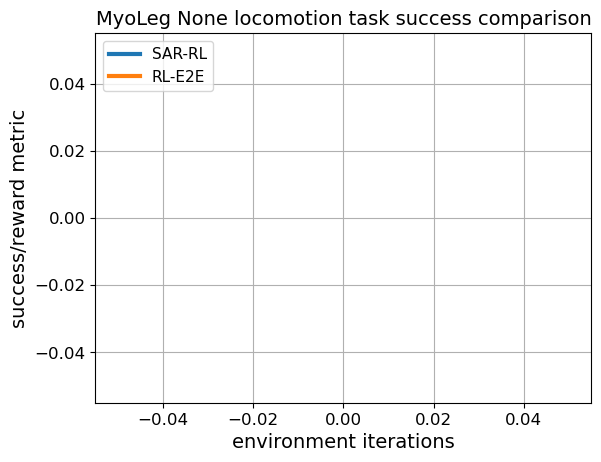

In [ ]:
plot_results(experiment='locomotion')

# Full training example 2: SAR x physiological manipulation

Now, we turn to using synergies for manipulation rather than locomotion. In this example:
- a policy is trained on an eight-object reorientation task, `Reorient8-v0`.
- after training, we collect muscle activation data from policy rollouts
- variance accounted for (VAF) by N synergies is computed. Here, we select N where VAF > 0.8.
- SAR is computed at this VAF threshold.
- SAR is used to train on a 100-object reorientation task, `Reorient100-v0`.

<strong>Note: we also provide the option of using pretrained policies/representations at some of the above steps. Run the code below depending on your preferences.</strong>

# Step 2.1

First, we acquire our synergistic action representation. We provide two options for this:

<strong>Option A: Get SAR from scratch (i.e., train on `Reorient8` as play period → get muscle activations → compute SAR).</strong>

<strong>Option B: Use the precomputed SAR.</strong>

## Option 2.1.A: Get SAR from scratch

In [ ]:
# a policy is trained on an eight-object reorientation task, Reorient8-v0
train(env_name='myoHandReorient8-v0', policy_name='play_period', timesteps=1e6, seed='0')

In [ ]:
# after training, we collect muscle activation data from policy rollouts
muscle_data = get_activations(name='play_period', env_name='myoHandReorient8-v0', seed='0', episodes=10)

In [ ]:
# VAF by N synergies is computed. Here, N is selected where VAF > 0.8
syn_dict = find_synergies(muscle_data, plot=True)
print("VAF by N synergies:", syn_dict)

In [ ]:
# make and load a video of the trained policy

video_name = 'play_period_vid'
get_vid(name='play_period', env_name='myoHandReorient8-v0', seed='0', episodes=10, video_name=video_name)
show_video(f"{video_name}.mp4")

In [ ]:
# SAR is computed at this VAF threshold
ica,pca,normalizer = compute_SAR(muscle_data, 20, save=False)

## Option 2.1.B: Use precomputed SAR

In [ ]:
# RUN THIS CELL TO USE PRECOMPUTED SAR
ica,pca,normalizer = load_manipulation_SAR()

# Step 2.2: Train on Reorient100 with synergies (SAR-RL)

In [ ]:
# SAR is used to train on a 100-object reorientation task, Reorient100-v0
SAR_RL(env_name='myoHandReorient100-v0', policy_name='SAR-RL', timesteps=1.5e6,
       seed='0', ica=ica, pca=pca, normalizer=normalizer, phi=.66)

In [ ]:
# make and load a video of the trained policy

video_name = 'SAR_vid'

get_vid(name='SAR-RL', env_name='myoHandReorient100-v0', seed='0', episodes=10, video_name=video_name,
        determ=True, pca=pca, ica=ica, normalizer=normalizer, phi=.66, is_sar=True, syn_nosyn=True)
show_video(f"{video_name}.mp4")

# Step 2.3 (optional): Train on Reorient100 with end-to-end RL (RL-E2E)

We can compare the performance of (A) pretraining for 1M steps on `Reorient8-v0`, getting SAR, and training with SAR-RL on `Reorient100-v0` for 2M steps with (B) training for 3M steps using end-to-end RL ('RL-E2E').

In [ ]:
train(env_name='myoHandReorient100-v0', policy_name='RL-E2E', timesteps=2.5e6, seed='0')

In [ ]:
# make and load a video of the trained policy

video_name = 'RL+E2E_vid'
get_vid('RL-E2E', 'myoHandReorient100-v0', '0', determ=False, episodes=10, video_name=video_name)
show_video(f"{video_name}.mp4")

# Step 2.4: Plot results

For convenience, a function is defined to automatically plot the results of these runs (ensure the names and seeds are preserved).

In [ ]:
plot_results(experiment='manipulation')

# Step 2.5 (optional): zero-shot testing manipulation policies on new unseen objects

We can optionally test these manipulation policies on unseen objects to determine their generalizability. Here, we implement two test
environments.

1. ReorientID-v0—1000 unseen objects generated by sampling from the same dimensions as those for the Reorient100-v0 set. Intuitively, this environment contains new objects with the same kind of shapes as those seen in the training set.

2. ReorientOOD-v0—1000 unseen objects generated by sampling from different dimensions as those for the Reorient100-v0 set. Intuitively, this environment contains new objects with different kinds of shapes as those seen in the training set.

In [ ]:
def zeroshot_test(name, test_env_name, env_name='myoHandReorient100-v0', seed='0', determ=True, ica=None,
                  pca=None, normalizer=None, phi=.66, episodes=500, is_sar=False, syn_nosyn=False):
    """
    Check zero-shot performance of policies on the test environments.

    name: str; name of the policy to test
    env_name: str; name of gym env the policy to test was trained on (Reorient100-v0).
    seed: str; seed of the policy to test
    test_env_name: str; name of the desired test env
    ica: if testing SAR-RL, the ICA object
    pca: if testing SAR-RL, the PCA object
    normalizer: if testing SAR-RL, the normalizer object
    phi: float; blend parameter between synergistic and nonsynergistic activations
    episodes: int; number of episodes to run on the test environment
    """
    if is_sar:
        if syn_nosyn:
            env = SynNoSynWrapper(gym.make(test_env_name), ica, pca, normalizer, phi)
        else:
            # env = SynergyWrapper(gym.make(test_env_name), ica, pca, normalizer, phi)
            env = SynergyWrapper(gym.make(test_env_name), ica, pca, normalizer)
    else:
        env = gym.make(test_env_name)
    env.reset()

    model = SAC.load(f'{name}_model_{env_name}_{seed}')
    vec = VecNormalize.load(f'{name}_env_{env_name}_{seed}', DummyVecEnv([lambda: env]))
    solved = []
    for i,_ in enumerate(range(episodes)):
        is_solved = []
        env.reset()
        done = False
        while not done:
            o = env.get_obs()
            o = vec.normalize_obs(o)
            a, __ = model.predict(o, deterministic=determ)
            next_o, r, done, *_, info = env.step(a)
            is_solved.append(info['solved'])

        if sum(is_solved) > 0:
            solved.append(1)
        else:
            solved.append(0)

    env.close()
    return np.mean(solved)

In [ ]:
# zero-shot testing RL-E2E policy

name = 'RL-E2E'

e2e_id = zeroshot_test(name, 'myoHandReorientID-v0')

e2e_ood = zeroshot_test(name, 'myoHandReorientOOD-v0')

In [ ]:
# zero-shot testing SAR-RL policy

name = 'SAR-RL'

sar_id = zeroshot_test(name, 'myoHandReorientID-v0', ica=ica, pca=pca,
                       normalizer=normalizer, is_sar=True, syn_nosyn=True)

sar_ood = zeroshot_test(name, 'myoHandReorientOOD-v0', ica=ica, pca=pca,
                        normalizer=normalizer, is_sar=True, syn_nosyn=True)

We can visualize these zero-shot generalization results by running the cell below.

In [ ]:
# plot results

zeroshot = {"SAR-RL": [sar_id,sar_ood],
            "RL-E2E": [e2e_id,e2e_ood]}

fig, ax = plt.subplots()
plot_zeroshot(ax, zeroshot)
fig.set_size_inches(6, 5)
plt.show()